# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [5]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

C:\Users\niroo\Desktop\Jupyter\Projets\Risk Management\RiskMetrics.py:287: RuntimeWarning: invalid value encountered in sqrt
  volatility=np.sqrt(np.dot(weights.T,np.dot(self.returns.cov(),weights)))*np.sqrt(252)


In [6]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [8]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [14]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [15]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

BTCUSDT 0
TRXUSDT 1
TRXUSDT 2
TRXUSDT 3
BTCUSDT 4
TRXUSDT 5
BNBUSDT 6
ETHUSDT 7
SOLUSDT 8
BNBUSDT 9
USDTTRY 10
JASMYUSDT 11
BNBUSDT 12
BBUSDT 13
USDTTRY 14
BNBUSDT 15
USDTTRY 16
TRXUSDT 17
USDTTRY 18
JASMYUSDT 19
BNBUSDT 20
BBUSDT 21
OMUSDT 22
OMUSDT 23
OMUSDT 24
TRXUSDT 25
BTCUSDT 26
OMUSDT 27
BTCUSDT 28
TRXUSDT 29
TRXUSDT 30
BBUSDT 31
BNBUSDT 32
TRXUSDT 33
BTCUSDT 34
TRXUSDT 35
BTCUSDT 36
MKRUSDT 37
BTCUSDT 38
MKRUSDT 39
EURUSDT 40
EURUSDT 41
BBUSDT 42
BNBUSDT 43
JASMYUSDT 44
PEPEUSDT 45
NOTUSDT 46
NOTUSDT 47
NOTUSDT 48
BBUSDT 49
BBUSDT 50
PEPEUSDT 51
JASMYUSDT 52
BTCUSDT 53
BTCUSDT 54
TRXUSDT 55
BTCUSDT 56
BNBUSDT 57
BTCUSDT 58
BNBUSDT 59
BTCUSDT 60
BNBUSDT 61
BTCUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
BNBUSDT 66
BTCUSDT 67
BNBUSDT 68
JASMYUSDT 69
JASMYUSDT 70
ENSUSDT 71
ARUSDT 72
BTCUSDT 73
UMAUSDT 74
BTCUSDT 75
UMAUSDT 76
ETHUSDT 77
XRPUSDT 78
BTCUSDT 79
XRPUSDT 80
BTCUSDT 81
NEARUSDT 82
BTCUSDT 83
LPTUSDT 84
BTCUSDT 85
NEARUSDT 86
EURUSDT 87
BTCUSDT 88
INJUSDT 89
BTCUSDT 90
FETU

In [16]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [17]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_17972\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [18]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [19]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [20]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,1979.7420,2004.3991,1.0000,1.0000,-28.6129,53.27,24.6571,1.2455
BTCUSDT,74833.4149,911.2802,1342.2043,0.6696,0.7006,13.0697,430.92,443.9897,22.4266
TRXUSDT,0.2647,512.9871,606.5591,0.3026,0.2994,80.2793,93.57,173.8493,8.7814
OMUSDT,1.1299,526.3213,55.0582,0.0275,0.0000,0.0000,-471.26,-471.2600,-23.8041
USDCUSDT,0.0000,0.0000,0.3226,0.0002,0.0000,0.0000,0.00,0.0000,0.0000
ETHUSDT,3654.5327,0.1328,0.1401,0.0001,0.0000,55.9949,0.01,56.0049,2.8289
NOTUSDT,0.0196,0.0000,0.0000,0.0000,0.0000,1.0078,0.00,1.0078,0.0509
UMAUSDT,4.0983,0.0000,0.0000,0.0000,0.0000,-5.0186,0.00,-5.0186,-0.2535
XLMUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
BCHUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [21]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.0,2004.40,2004.40,0.00
BTCUSDT,0.67,0.7,1342.20,1404.27,62.07
TRXUSDT,0.30,0.3,606.56,600.13,-6.43
NOTUSDT,0.00,0.0,0.00,0.00,0.00
UMAUSDT,0.00,0.0,0.00,0.00,0.00
XLMUSDT,0.00,0.0,0.00,0.00,0.00
BCHUSDT,0.00,0.0,0.00,0.00,0.00
LINKUSDT,0.00,0.0,0.00,0.00,0.00
ADAUSDT,0.00,0.0,0.00,0.00,0.00
DOGEUSDT,0.00,0.0,0.00,0.00,0.00


In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 053dc1689d547759b6c717f28a6bb458fe178567)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: f58ebebc4c0ab99e17b31bafed2c99d19a5fe91e)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-10-18   -212.366437
2025-10-19   -178.678951
2025-10-20   -151.896382
2025-10-21   -183.264073
2025-10-22     36.155285
Name: Total, Length: 395, dtype: float64

<Axes: >

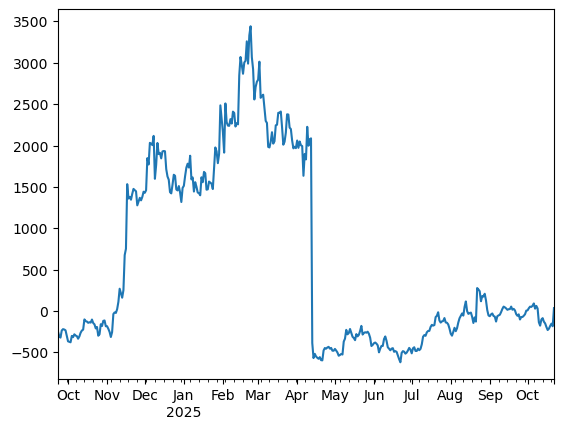

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-09-22    -45.323121
2025-09-23    -20.406501
2025-09-24     17.724228
2025-09-25    -61.920400
2025-09-26     29.559911
2025-09-27      0.855447
2025-09-28     14.379318
2025-09-29     18.308190
2025-09-30     44.140745
2025-10-01      2.513205
2025-10-02     25.932412
2025-10-03     19.426799
2025-10-04     -3.164062
2025-10-05     14.336500
2025-10-06     27.547427
2025-10-07    -62.874522
2025-10-08     32.817434
2025-10-09    -30.933544
2025-10-10   -166.928288
2025-10-11    -40.282600
2025-10-12     73.634719
2025-10-13     16.971318
2025-10-14    -42.740069
2025-10-15    -21.169315
2025-10-16    -43.082537
2025-10-17    -36.579324
2025-10-18     16.471990
2025-10-19     33.687486
2025-10-20     26.782570
2025-10-21    -31.367691
2025-10-22    219.419358
Name: Total, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-365.7240013371763, -950.5160328166937)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
start_date=datetime.datetime(2024,5,11)
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(weights_ex_post.columns,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(weights_ex_post.columns,temp_end)
binance_data=prices.combine_first(last_data)
binance_data=binance_data.sort_index()
binance_data = binance_data[~binance_data.index.duplicated(keep='first')]
binance_data.index=pd.to_datetime(binance_data.index)

LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved


In [51]:
binance_data=np.log(1+binance_data.pct_change())

C:\Users\niroo\AppData\Local\Temp\ipykernel_17972\2713676895.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=set(binance_data.index)

In [53]:
common_date=weight_date.intersection(binance_date)

In [54]:
binance_data2=binance_data.loc[list(common_date)].copy().sort_index()
weights_ex_post2=weights_ex_post.loc[list(common_date)].copy().sort_index()

In [55]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post2[col]*binance_data2[col]
    

In [56]:
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [57]:
variance_decomposition=variance_decomposition_ex_post(quantities.fillna(0).loc['2025-09':],price_pnl.loc['2025-09':])
variance_decomposition_pct=variance_decomposition.copy()
total_var=variance_decomposition['Variance'].sum()
for col in variance_decomposition_pct.columns:
    variance_decomposition_pct[col]=variance_decomposition[col]/total_var

In [58]:
variance_decomposition_pct.round(4)

,Variance,Correlation,Idiosyncratic
BNBUSDT,0.0000,0.0000,0.0000
BTCUSDT,0.6081,0.1180,0.4901
ETHUSDT,0.0001,0.0001,0.0000
OMUSDT,0.0658,0.0452,0.0206
PEPEUSDT,0.0000,0.0000,0.0000
SOLUSDT,0.0001,0.0001,0.0000
TRXUSDT,0.3260,0.0995,0.2265
USDCUSDT,0.0000,0.0000,0.0000
BBUSDT,0.0000,0.0000,0.0000
JASMYUSDT,0.0000,0.0000,0.0000


<Axes: >

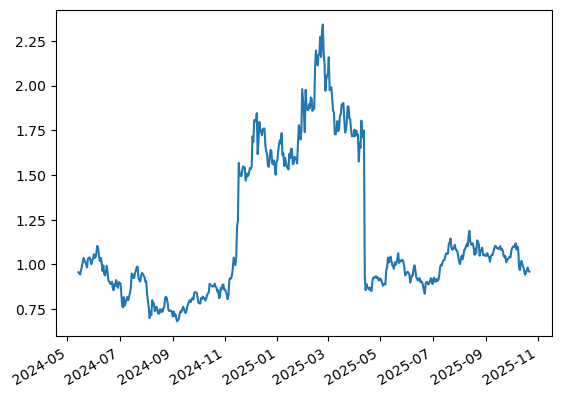

In [59]:
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

In [60]:
(1+historical_ptf['Historical Portfolio'].loc['2025-08-30':]).cumprod()*100

2025-08-30    100.353789
2025-08-31    100.051951
2025-09-01     99.535062
2025-09-02    100.710311
2025-09-03    101.129679
2025-09-04     99.485482
2025-09-05     99.220782
2025-09-06     96.554921
2025-09-07     99.424509
2025-09-08    100.075140
2025-09-09    100.234767
2025-09-10    101.796175
2025-09-11    103.608254
2025-09-12    104.995500
2025-09-13    104.842955
2025-09-14    103.865797
2025-09-15    103.865797
2025-09-16    103.281206
2025-09-17    103.568122
2025-09-18    104.921080
2025-09-19    102.921338
2025-09-20    103.359550
2025-09-21    102.378707
2025-09-22     99.769367
2025-09-23     98.889202
2025-09-24     99.572478
2025-09-25     96.315933
2025-09-26     97.867406
2025-09-27     97.842644
2025-09-28     98.567105
2025-09-29     99.249159
2025-09-30     98.997365
2025-10-01    102.626041
2025-10-02    103.907215
2025-10-03    104.714896
2025-10-04    104.352599
2025-10-05    104.822214
2025-10-06    106.367034
2025-10-07    103.113320
2025-10-08    104.743925


## Ex ante data

In [62]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [65]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [66]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [69]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.6648
ZECUSDT,0.3352
FLOKIUSDT,0.0000
OMUSDT,0.0000
INJUSDT,0.0000
STXUSDT,0.0000
AAVEUSDT,0.0000
ICPUSDT,0.0000
SUIUSDT,0.0000
APTUSDT,0.0000


In [70]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.664824
ZECUSDT,0.335176


In [71]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

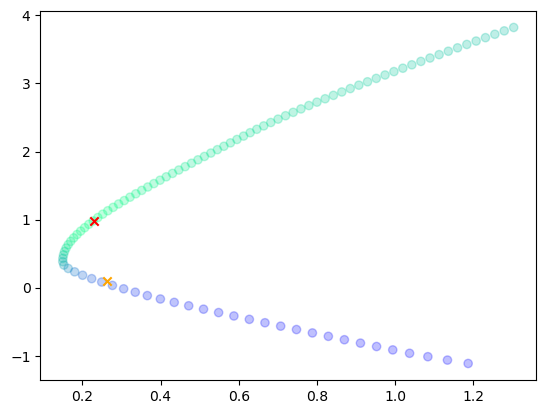

In [72]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [73]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [74]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1342.2043,0.6696,0.0000,0.6696
TRXUSDT,606.5591,0.3026,0.0000,0.3026
OMUSDT,55.0582,0.0275,0.0000,0.0275
USDCUSDT,0.3226,0.0002,0.0000,0.0002
ETHUSDT,0.1401,0.0001,0.0000,0.0001
SOLUSDT,0.0850,0.0000,0.0000,0.0000
BNBUSDT,0.0298,0.0000,0.0915,-0.0915
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.6977,-0.6977
ZECUSDT,0.0000,0.0000,0.1193,-0.1193


### Current results

In [76]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [77]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.906178
TRXUSDT,0.093822


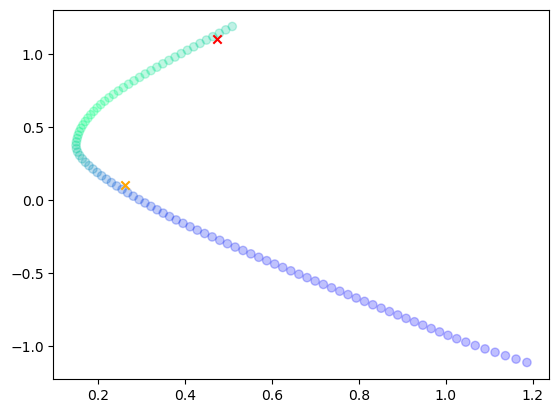

In [78]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [79]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1342.2043,0.6696,0.0000,0.6696
TRXUSDT,606.5591,0.3026,0.0938,0.2088
OMUSDT,55.0582,0.0275,0.0000,0.0275
USDCUSDT,0.3226,0.0002,0.0000,0.0002
ETHUSDT,0.1401,0.0001,0.0000,0.0001
SOLUSDT,0.0850,0.0000,0.0000,0.0000
BNBUSDT,0.0298,0.0000,0.9062,-0.9062
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [81]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [82]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

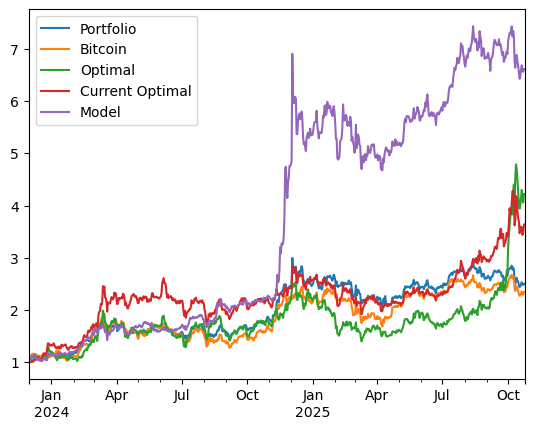

In [83]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [84]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

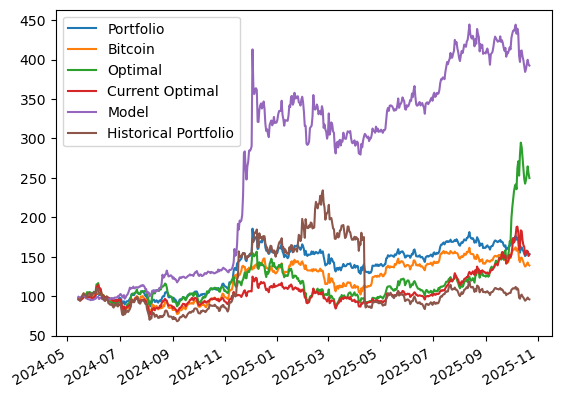

In [85]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

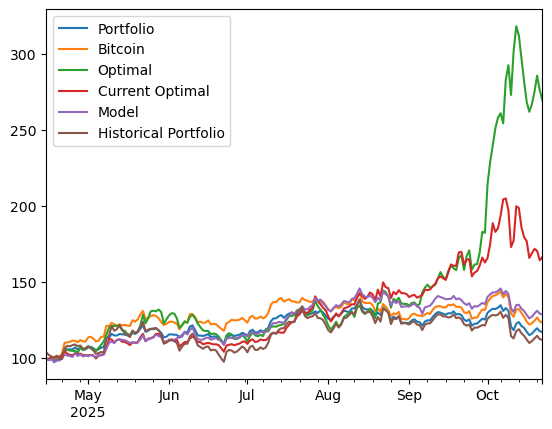

In [86]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

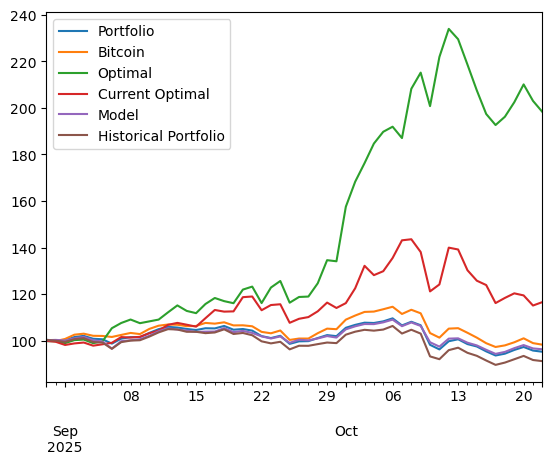

In [87]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [88]:
((1+current_perf.loc['2025-09':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-09-01,100.124689,100.911403,99.164922,98.624005,99.756866,99.483380
2025-09-02,101.500090,102.744604,100.466028,99.290354,100.671284,100.658019
2025-09-03,101.990775,103.173841,100.697729,99.671102,101.276947,101.077169
2025-09-04,100.763394,102.269505,99.164416,98.321105,99.878887,99.433826
2025-09-05,100.534917,102.204021,99.939146,98.914562,99.290841,99.169263
2025-09-06,98.667230,101.767137,105.590497,99.553761,96.253927,96.504786
2025-09-07,100.804242,102.640198,107.833096,102.026983,99.459434,99.372884
2025-09-08,101.450504,103.493588,109.321893,101.822680,99.837152,100.023178
2025-09-09,101.459414,103.013320,107.748622,102.134215,100.280858,100.182721
2025-09-10,103.254886,105.218521,108.522126,103.661247,101.762696,101.743319


## Volatilities

In [90]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.565863
 dtype: float64,
 0.5658627386387614)

In [91]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.263248
 dtype: float64,
 0.2632481135006564)

In [92]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.365732
Bitcoin            0.398671
Optimal            0.490175
Current Optimal    0.439065
Model              0.481600
dtype: float64

In [93]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.17909791054833027

In [94]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-1.678942073218283

<Axes: >

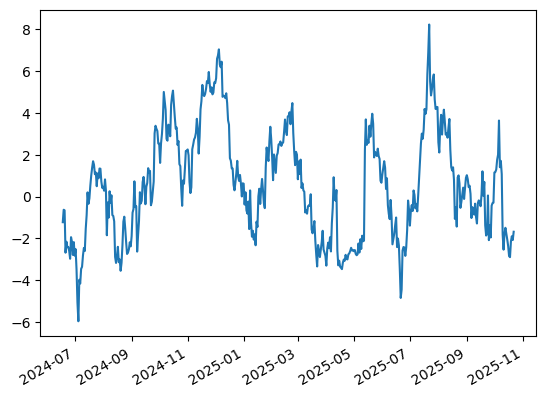

In [95]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [96]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.3782347582995388

## Risk Contribution

In [98]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
ZECUSDT,109.6780,0.6189,0.5958,0.0231
BNBUSDT,43.4566,0.3811,0.3580,0.0231
Portfolio,153.1346,1.0000,0.9538,0.0462


In [99]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,59.232826,0.97427,0.951592,0.022677
TRXUSDT,1.256101,0.02573,0.003053,0.022677
Portfolio,60.488927,1.00000,0.954645,0.045355


In [100]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,4.016440,0.243056,0.100783,0.142273
BTCUSDT,0.806864,0.670858,0.489546,0.181312
OMUSDT,-1.760080,0.086087,0.018290,0.067797
Portfolio,3.063223,1.000000,0.608619,0.391381


# Value At Risk

## Historical

### Optimal Weights

In [104]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06506000756816446, -0.07054075793930571)

### Current Weights

In [106]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03843379503339058, -0.05900654683752856)

In [107]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [108]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.020267
TRXUSDT     -0.016816
OMUSDT      -0.002214
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.039297
Name: 2025-08-25 00:00:00, dtype: float64

In [109]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.035546
TRXUSDT     -0.015893
OMUSDT      -0.007567
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.059007
dtype: float64

## Parametric

### Optimal Weights

In [112]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.08292500089521032, -0.10270803820322819)

### Current Weights

In [114]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03857799525768072, -0.04778137073205248)

## Multivariate

### Optimal Weights

In [117]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07532487185761065, -0.08841490396143646)

### Current Weights

In [119]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03781885862232577, -0.04289693445778649)

In [120]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.025904
TRXUSDT     -0.008645
OMUSDT      -0.003592
Portfolio   -0.038141
dtype: float64

In [121]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.026295
TRXUSDT     -0.008697
OMUSDT      -0.003633
Portfolio   -0.038625
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [125]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07481767040335077, -0.08686926369606285)

### Current Weights

In [127]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03728334693078132, -0.04311044251747042)

In [128]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [131]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07222661239016256, -0.08643646202334578)

### Current Weights

In [133]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.040093705748059295, -0.046192289088767886)

In [134]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [137]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.1919508124764793, -0.23193596676445516)

### Current Weights

In [139]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07724702055082833, -0.09354041796324224)

In [140]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [143]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [144]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08374157697789267, -0.09580321823154145)

### Current Weights

In [146]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.038531369812879065, -0.043722891426178634)

In [147]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [148]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.036815,-0.025608,-0.018820,-0.025904,-0.027206
TRXUSDT,-0.007985,-0.009114,-0.006308,-0.008645,-0.008908
OMUSDT,-0.001110,-0.003414,-0.002361,-0.003592,-0.003650
Portfolio,-0.045911,-0.038136,-0.027488,-0.038141,-0.039763


In [149]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.037095,-0.025669,-0.018110,-0.026295,-0.027645
TRXUSDT,-0.008020,-0.009728,-0.007397,-0.008697,-0.009041
OMUSDT,-0.001401,-0.003298,-0.002243,-0.003633,-0.003687
Portfolio,-0.046516,-0.038695,-0.027750,-0.038625,-0.040372


## VaR Violation

In [151]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.048917,-0.070592,-0.068296,-0.015421
2024-01-15,-0.048917,-0.073789,-0.071608,0.052106
2024-01-16,-0.048917,-0.073490,-0.070624,-0.011420
2024-01-17,-0.048917,-0.073932,-0.070881,-0.016128
2024-01-18,-0.048917,-0.073640,-0.070640,0.001492
...,...,...,...,...
2025-10-20,-0.072082,-0.132809,-0.110062,0.037878
2025-10-21,-0.072082,-0.134700,-0.116430,-0.033688
2025-10-22,-0.072082,-0.131879,-0.111185,-0.023319
2025-10-23,-0.072082,-0.131151,-0.112258,0.040036


In [152]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.050603,-0.054522,-0.049959,-0.032094
2023-12-16,-0.050603,-0.054121,-0.049816,0.009522
2023-12-17,-0.050603,-0.055039,-0.052879,-0.016909
2023-12-18,-0.050603,-0.055680,-0.052935,0.016985
2023-12-19,-0.050603,-0.051616,-0.052101,-0.006238
...,...,...,...,...
2025-10-20,-0.071579,-0.063749,-0.071461,0.013373
2025-10-21,-0.071579,-0.062772,-0.070797,-0.015837
2025-10-22,-0.070709,-0.061564,-0.068588,-0.005276
2025-10-23,-0.070709,-0.060891,-0.066694,0.009220


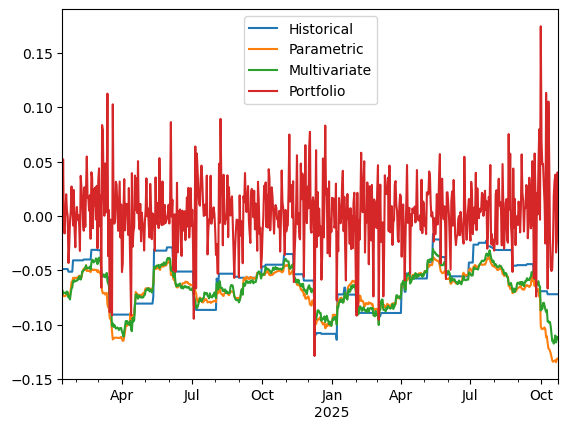

In [153]:
var_data.plot()
plt.show()

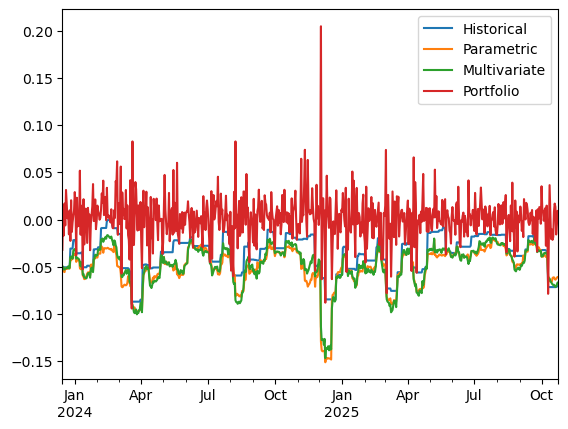

In [154]:
current_var_data.plot()
plt.show()


In [155]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032308,0.013846,0.013846
Kupiec Stat,4.870711,24.770919,24.770919
P-value,0.027316,0.000001,0.000001


In [156]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069118,0.014706,0.008824
Kupiec Stat,4.699368,24.405291,36.381246
P-value,0.030174,0.000001,0.0


# Principal Component Analysis

## Historical PCA

In [214]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.84126829, 0.07194238, 0.03235861, 0.02908355, 0.02534716])

In [160]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.021247
ADAUSDT      0.022401
ALGOUSDT     0.023992
APTUSDT      0.023027
ARBUSDT      0.031133
ATOMUSDT     0.022741
AVAXUSDT     0.024485
BCHUSDT      0.012940
BNBUSDT      0.012806
BONKUSDT     0.031354
BTCUSDT      0.007972
CAKEUSDT     0.023370
CRVUSDT      0.029709
DOGEUSDT     0.025826
DOTUSDT      0.024905
ETCUSDT      0.023294
ETHUSDT      0.017661
FDUSDUSDT    0.000130
FILUSDT      0.023977
FLOKIUSDT    0.030142
HBARUSDT     0.024077
ICPUSDT      0.025977
IMXUSDT      0.031682
INJUSDT      0.029626
LDOUSDT      0.030441
LINKUSDT     0.024635
LTCUSDT      0.018432
NEARUSDT     0.022867
NEXOUSDT     0.006420
OMUSDT       0.030918
PAXGUSDT     0.000692
PEPEUSDT     0.027842
QNTUSDT      0.016406
SEIUSDT      0.025928
SHIBUSDT     0.019741
SOLUSDT      0.020068
STXUSDT      0.025908
SUIUSDT      0.025138
TRXUSDT      0.005539
UNIUSDT      0.025717
USDCUSDT     0.000017
VETUSDT      0.024219
WBETHUSDT    0.018526
WBTCUSDT     0.007909
WLDUSDT      0.030196
XLMUSDT   

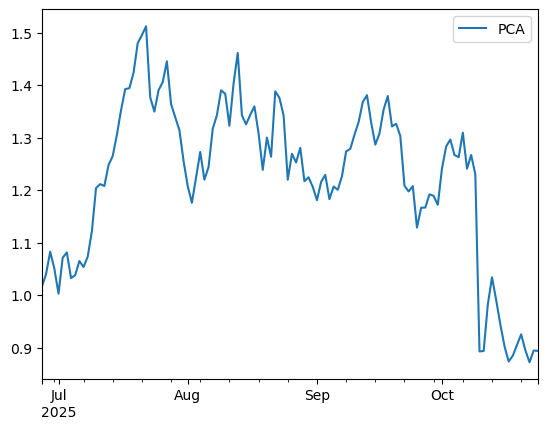

In [161]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

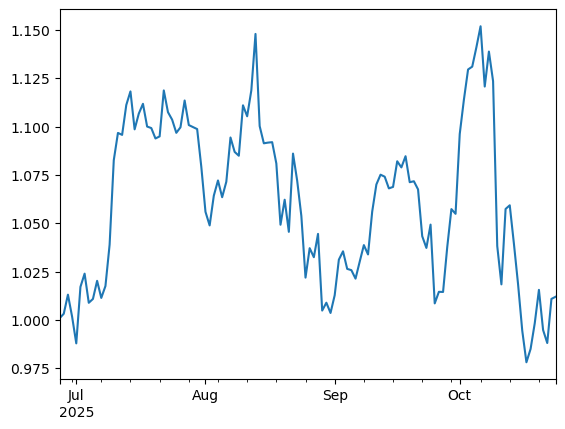

In [162]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
DOTUSDT      0.123486
SHIBUSDT     0.135990
STXUSDT      0.136621
ICPUSDT      0.149928
VETUSDT      0.161137
FILUSDT      0.161208
ATOMUSDT     0.163286
ADAUSDT      0.174317
PEPEUSDT     0.174581
NEARUSDT     0.194385
ETCUSDT      0.195338
DOGEUSDT     0.195841
SUIUSDT      0.209320
INJUSDT      0.211929
WBETHUSDT    0.211968
APTUSDT      0.212502
ETHUSDT      0.231344
LINKUSDT     0.234757
SOLUSDT      0.236086
dtype: float64

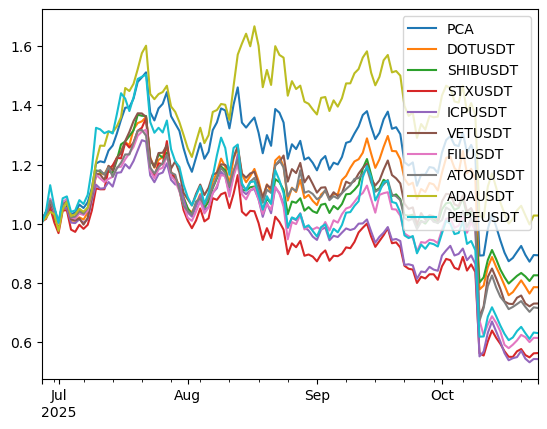

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

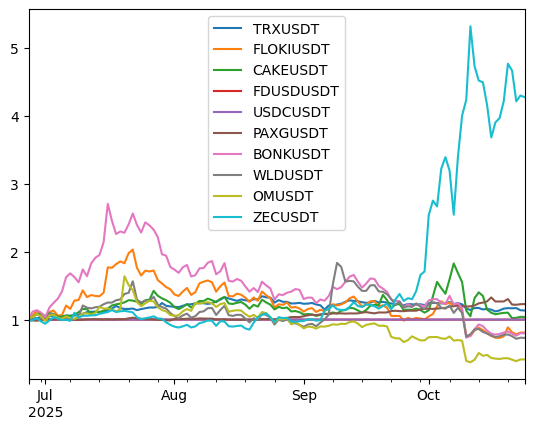

In [165]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [167]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77734594, 0.14152792, 0.03582339, 0.02678107, 0.01852168])

In [168]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT     0.058658
TRXUSDT     0.039533
OMUSDT      0.296330
ETHUSDT     0.134527
SOLUSDT     0.154530
BNBUSDT     0.098392
PEPEUSDT    0.213034
PAXGUSDT    0.004996
Name: PC1, dtype: float64

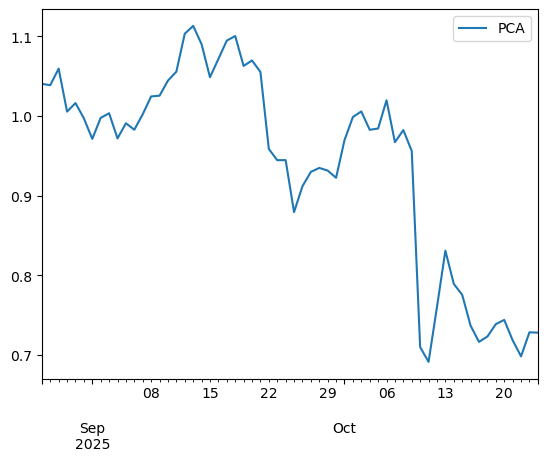

In [169]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

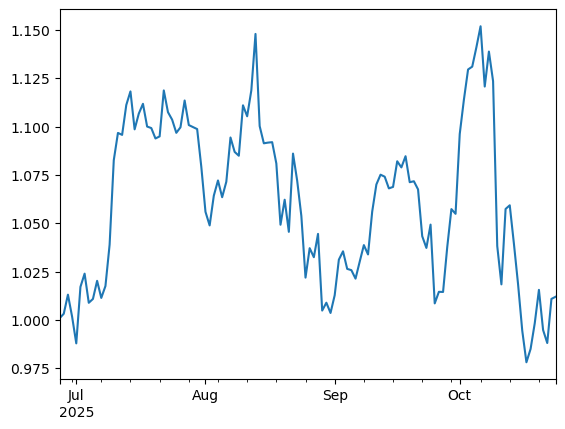

In [170]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [171]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
PEPEUSDT    0.229359
ETHUSDT     0.257334
SOLUSDT     0.259321
BNBUSDT     0.342449
BTCUSDT     0.349738
TRXUSDT     0.411287
OMUSDT      0.431777
PAXGUSDT    0.479473
dtype: float64

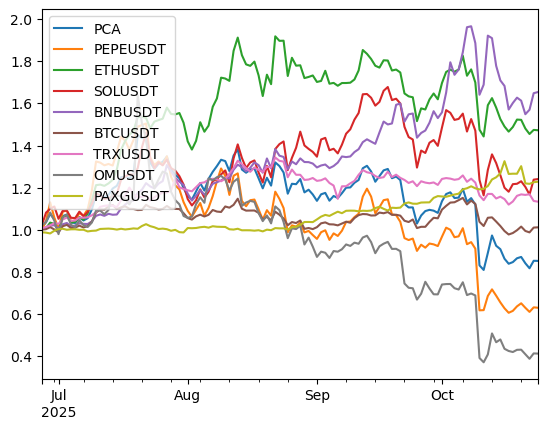

In [172]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [174]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.952906
SOLUSDT     1.330500
ETHUSDT     1.130000
OMUSDT      1.102563
BTCUSDT     1.000000
BNBUSDT     0.708498
TRXUSDT     0.350280
PAXGUSDT    0.033210
Name: BTCUSDT, dtype: float64

In [175]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

OMUSDT      3.122494
PEPEUSDT    2.597061
SOLUSDT     2.036805
BNBUSDT     1.631044
ETHUSDT     1.626638
BTCUSDT     1.000000
TRXUSDT     0.535033
PAXGUSDT    0.163988
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [177]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [178]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.611554
BTCUSDT,0.245613
ETHUSDT,0.090880
OMUSDT,0.086057
BNBUSDT,0.080508
TRXUSDT,0.025099
SOLUSDT,-0.018815
PAXGUSDT,-0.030823


### Regression to PCA

In [180]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

2.3863869331971137

In [181]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT     1.235012
ETHUSDT     1.095515
BTCUSDT     1.029941
PCA         1.000000
SOLUSDT     0.793619
PAXGUSDT    0.643913
PEPEUSDT    0.436706
TRXUSDT     0.357173
OMUSDT      0.233256
dtype: float64

In [182]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

TRXUSDT     2.756037
BTCUSDT     2.352141
ETHUSDT     1.388144
SOLUSDT     1.051502
PCA         1.000000
PEPEUSDT    0.876229
BNBUSDT     0.866523
PAXGUSDT    0.593589
OMUSDT      0.535306
dtype: float64

### Correlation Matrix

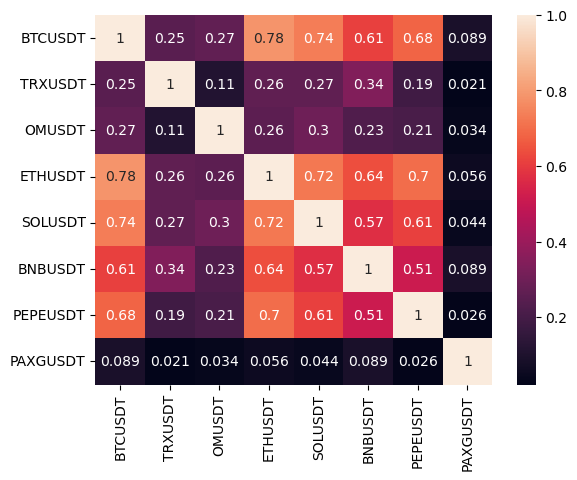

In [184]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

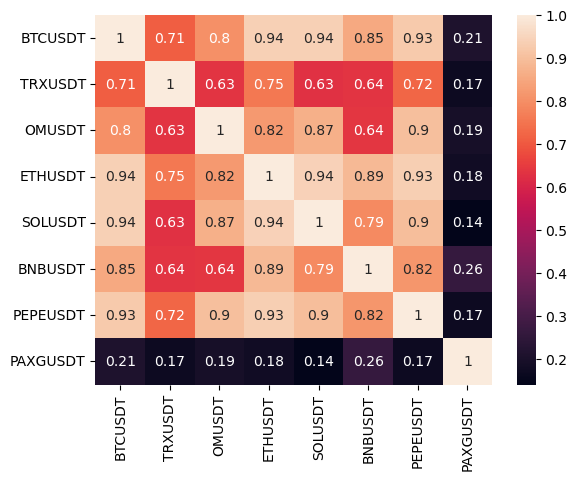

In [185]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [186]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [187]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

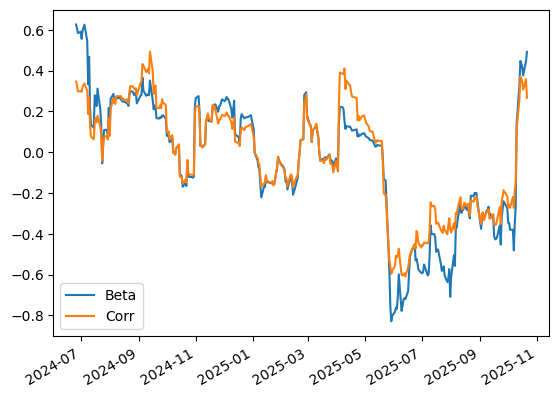

In [188]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [190]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.107613,0.000000,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.000000,0.379495,0.104623,0.000000,0.000000,0.000000,0.000000,0.515881
2024-02-08,0.000000,0.066364,0.047113,0.191143,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.000000,0.705974,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000920,0.000000,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [191]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [192]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-03-18,0.000000,0.985827,0.014157,0.0,0.0,0.0,0.0,0.000016,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-04-17,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.497450,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-05-17,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.043522,0.000000,0.0,0.0,0.048670,0.0,0.000000,0.000000,0.0,0.145040
2025-06-16,0.064421,0.000000,0.006973,0.0,0.0,0.0,0.0,0.578839,0.000000,0.000000,...,0.000000,0.089702,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-07-16,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.227950,0.000000,0.325456,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.260782,0.0,0.000000
2025-08-15,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.209174,0.000000,...,0.569556,0.000000,0.0,0.0,0.181458,0.0,0.000000,0.000000,0.0,0.000000
2025-09-14,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.081916,0.000000,0.0,0.474283
2025-10-14,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.579357
2025-10-24,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [193]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

ZECUSDT     0.579357
CAKEUSDT    0.420643
STXUSDT     0.000000
NEARUSDT    0.000000
NEXOUSDT    0.000000
OMUSDT      0.000000
Name: 2025-10-14 00:00:00, dtype: float64

In [194]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
